In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
# import torch
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
tf.config.run_functions_eagerly(True)
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras.layers import (
    Input,
    Conv3D,
    MaxPooling3D,
    UpSampling3D,
    concatenate,
    Activation,
)

2024-06-12 13:54:18.454985: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 13:54:18.693574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 13:54:18.696191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 13:54:19.482867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
train_input_path = "Data/Train/Input"
train_label_path = "Data/Train/Label"

test_input_path = "Data/Test/Input"
test_label_path = "Data/Test/Label"

np_array_input_path = "Data/NP_arrays/input_images_8.npy"
np_array_label_path = "Data/NP_arrays/label_images_8.npy"

In [3]:
np_array_input = np.load(np_array_input_path)
np_array_label = np.load(np_array_label_path)

In [4]:
np_array_label[np_array_label == 1] = 0
np_array_label[np_array_label == 2] = 1

In [5]:
train_input, test_input, train_label, test_label = train_test_split(np_array_input, np_array_label, test_size=0.2, random_state=42)

In [6]:
print(train_label.shape)
print(train_input.shape)
print(test_label.shape)
print(test_input.shape)

(13, 256, 128, 256)
(13, 256, 128, 256)
(4, 256, 128, 256)
(4, 256, 128, 256)


In [7]:
def extract_patches(data, patch_size):
    patches = []
    shape = data.shape
    for i in range(0, shape[0] - patch_size[0] + 1, patch_size[0]):
        for j in range(0, shape[1] - patch_size[1] + 1, patch_size[1]):
            for k in range(0, shape[2] - patch_size[2] + 1, patch_size[2]):
                patch = data[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]]
                patches.append(patch[:])
    return np.array(patches)

In [8]:
def convert_to_patched(data,label,patch_size):
    data_patched = None
    label_patched = None

    for i in range(len(data)):
        if data_patched is None:
            data_patched = extract_patches(data[i],patch_size)
            label_patched = extract_patches(label[i],patch_size)

        else:
            data_patched = np.concatenate((data_patched,extract_patches(data[i],patch_size)))
            label_patched = np.concatenate((label_patched,extract_patches(label[i],patch_size)))
    
    return [data_patched,label_patched]

In [15]:
def get_useful(inp,lbl):
    ret_inp = []
    ret_lbl = []
    
    for i in range(len(inp)):
        
        ratio = np.sum(lbl[i]) / lbl[i].size

        if ratio > 0.2:
            ret_inp.append(inp[i])
            ret_lbl.append(lbl[i])
    
    return [np.array(ret_inp), np.array(ret_lbl)]

In [10]:
patch_size = (16, 16, 16)
train_input_patched, train_label_patched = convert_to_patched(train_input, train_label, patch_size)

In [11]:
test_input_patched, test_label_patched = convert_to_patched(test_input, test_label, patch_size)

In [12]:
train_input_patched_useful,train_label_patched_useful = get_useful(train_input_patched,train_label_patched)
train_input_patched_useful = np.expand_dims(train_input_patched_useful, axis=-1)

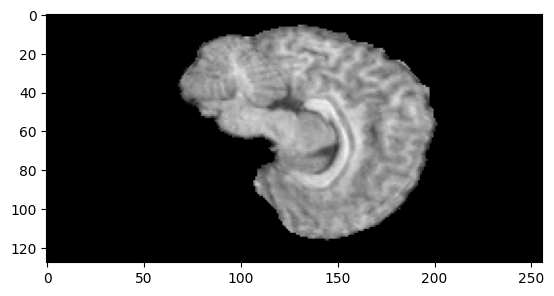

In [13]:
plt.imshow(train_input[0][120],cmap = 'gray')

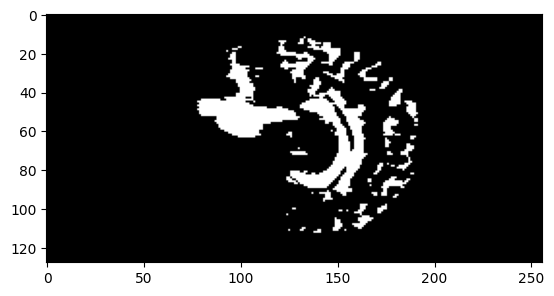

In [14]:
plt.imshow(train_label[0][120],cmap = 'gray')

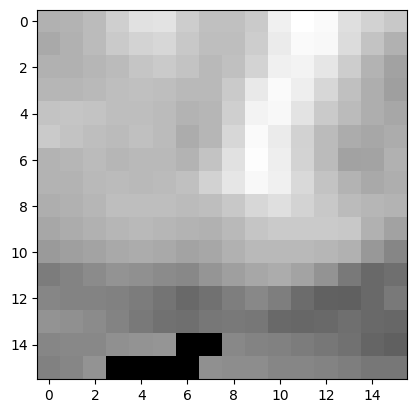

In [16]:
ind = 140
who = train_input_patched_useful[ind][0]
who_lb = train_label_patched_useful[ind][0]
plt.imshow(who,cmap='gray')

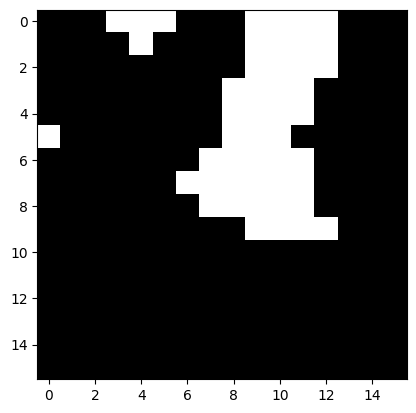

In [17]:
plt.imshow(who_lb,cmap = 'gray')

In [18]:
def unet_3d(input_shape):
    inputs = layers.Input(input_shape)

    # Encoding path
    conv1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D((2, 2, 2), padding='same')(conv1)

    conv2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D((2, 2, 2), padding='same')(conv2)

    conv3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling3D((2, 2, 2), padding='same')(conv3)

    # Bottleneck
    conv4 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)

    # Decoding path
    up5 = layers.Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)

    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [19]:
def small_unet_3d(input_shape):
    inputs = layers.Input(input_shape)

    # Encoding path
    conv1 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D((2, 2, 2))(conv1)  # Output shape: (10, 10, 10, 16)

    conv2 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D((2, 2, 2))(conv2)  # Output shape: (5, 5, 5, 32)

    # Bottleneck
    conv3 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv3)

    # Decoding path
    up4 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv3)
    up4 = layers.concatenate([up4, conv2], axis=-1)
    conv4 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up4)
    conv4 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv4)

    up5 = layers.Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv1], axis=-1)
    conv5 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv5)

    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(conv5)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [20]:
batch_size = 1
epochs = 20
input_shape = (16, 16, 16, 1) 

model = small_unet_3d(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 16, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 16, 16, 16, 16)       448       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 16)       6928      ['conv3d[0][0]']              
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 8, 8, 8, 16)          0         ['conv3d_1[0][0]']            
 D)                                                                                           

2024-06-12 13:55:01.807153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 13:55:01.807503: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


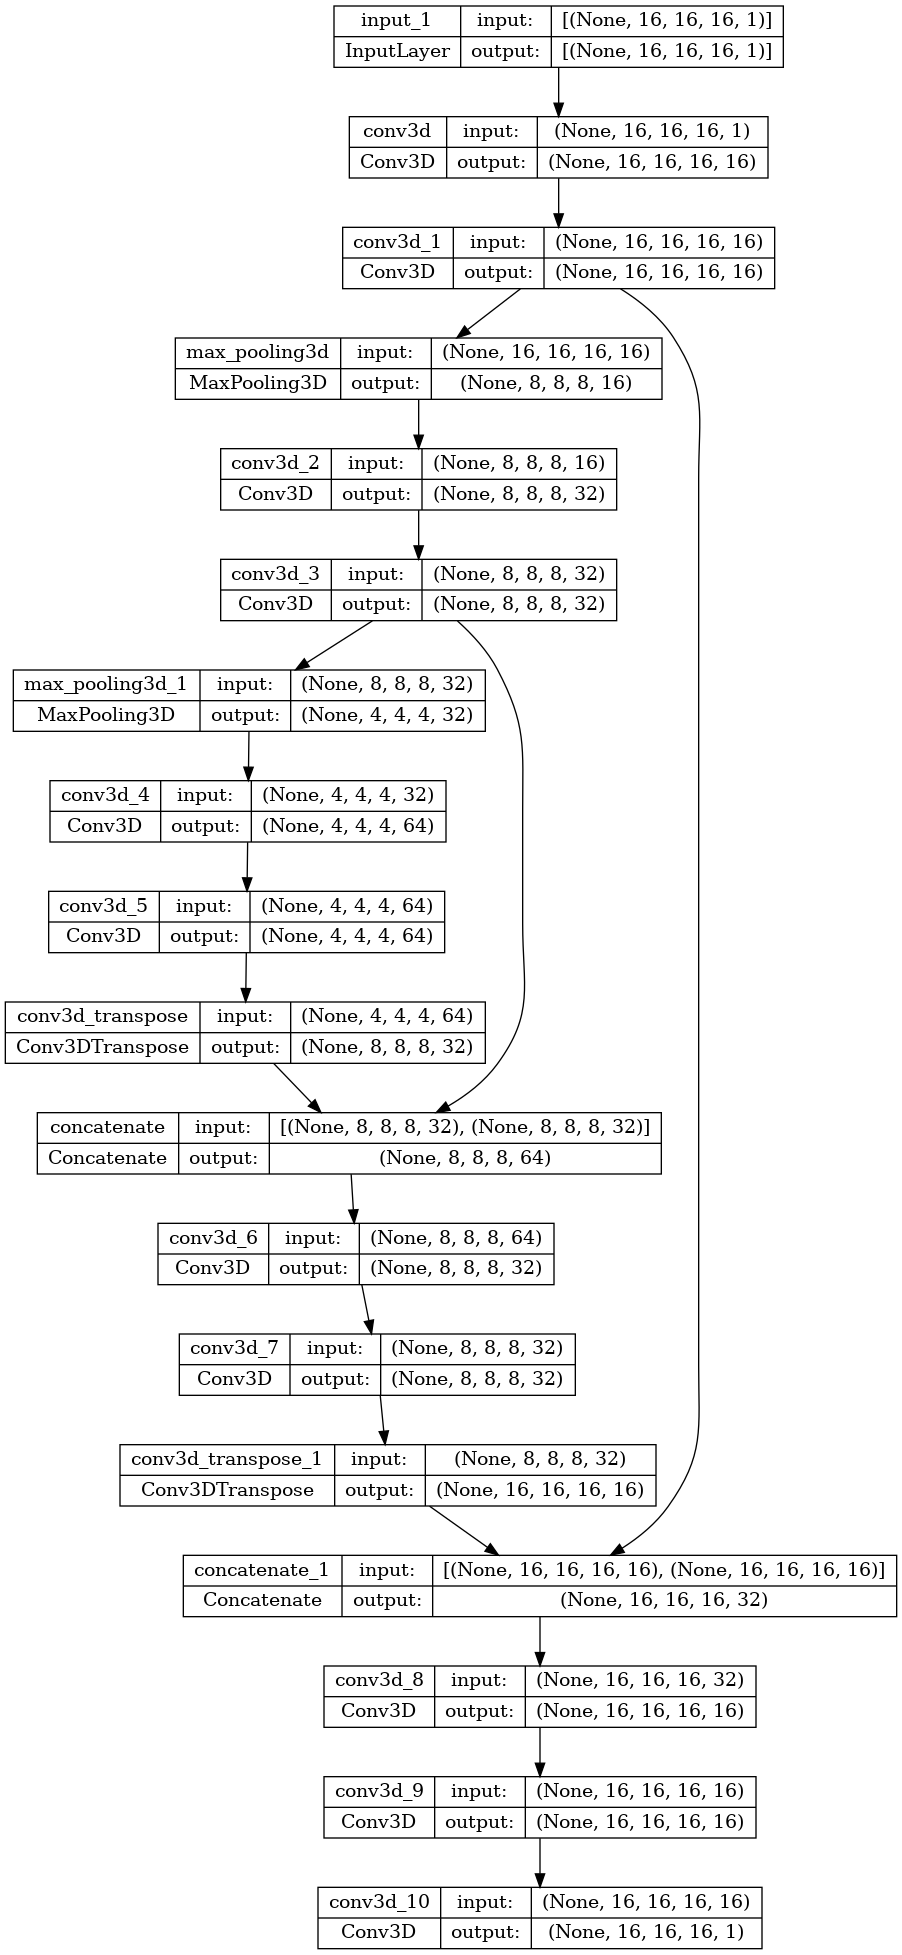

In [21]:
plot_model(model, show_shapes=True)

In [22]:
model.fit(train_input_patched_useful, train_label_patched_useful, batch_size=batch_size, epochs=epochs)

Epoch 1/20


/home/shivang/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2171/2171 [==============================] - 167s 77ms/step - loss: 0.6826 - accuracy: 0.5427
Epoch 2/20
2171/2171 [==============================] - 164s 76ms/step - loss: 0.6764 - accuracy: 0.5432
Epoch 3/20
2171/2171 [==============================] - 172s 79ms/step - loss: 0.6749 - accuracy: 0.5432
Epoch 4/20
2171/2171 [==============================] - 171s 79ms/step - loss: 0.6683 - accuracy: 0.5432
Epoch 5/20
2171/2171 [==============================] - 182s 84ms/step - loss: 0.5996 - accuracy: 0.6523
Epoch 6/20
2171/2171 [==============================] - 172s 79ms/step - loss: 0.5227 - accuracy: 0.7374
Epoch 7/20
2171/2171 [==============================] - 170s 78ms/step - loss: 0.4924 - accuracy: 0.7574
Epoch 8/20
2171/2171 [==============================] - 184s 85ms/step - loss: 0.4760 - accuracy: 0.7684
Epoch 9/20
2171/2171 [==============================] - 180s 83ms/step - loss: 0.4544 - accuracy: 0.7822
Epoch 10/20
2171/2171 [==============================] - 182s 84ms

In [23]:
model.save('Models/V_net_GM.keras')

In [24]:
# model = load_model('Models/Patched_20_model.keras')

In [25]:
test_input_patched_useful,test_label_patched_useful = get_useful(test_input_patched,test_label_patched)
test_input_patched_useful = np.expand_dims(test_input_patched_useful, axis=-1)

In [26]:
print(test_input_patched_useful.shape)

(903, 16, 16, 16, 1)


In [27]:
prediction = model.predict(test_input_patched_useful)

29/29 [==============================] - 2s 74ms/step


In [28]:
prediction = np.squeeze(prediction, axis=-1)

In [29]:
prediction[prediction <  0.5] = 0
prediction[prediction >= 0.5] = 1

In [30]:
prediction.shape

(903, 16, 16, 16)

In [31]:
test_label_patched_useful.shape

(903, 16, 16, 16)

In [32]:
def compute_iou(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool_)
    y_pred = np.asarray(y_pred).astype(np.bool_)
    
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou

In [33]:
iou = compute_iou(test_label_patched_useful,prediction)

In [34]:
print(iou)

0.6413381974368186
